<a href="https://colab.research.google.com/github/anasnafis77/Lunion/blob/master/Machine%20Learning/Deep%20Learning%20pendeteksi%20penyakit%20paru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Lung disease is a very common human disease, especially when Covid-19 pandemic occurs. Lung disease can be divided as chronical lung disease and non-chronical lung disease. The examples for chronical lung diseases are COPD, bronchiectasis, and Asthma. Otherwise, non-chornical lung diseases includes Upper Respiratory Tract Infection (URTI), Lower Respiratory Tract Infection (LRTI), Bronciolithis, and Pneunomia. Latest study about Covid-19 indicates that Pneunomia is the one of symptomps of Covid-19 infection. Therefore, by detecting the lung condition through respiratory sound, We can monitor ourself from Covid-19 infection without replacing the proven testing of Covid-19 such as antigen test and PCR.

# Acquiring data

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.67G/3.69G [00:24<00:00, 156MB/s]
100% 3.69G/3.69G [00:24<00:00, 163MB/s]


In [5]:
!ls

kaggle.json  respiratory-sound-database.zip  sample_data


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('respiratory-sound-database.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()


Buat dataframe database suara paru

In [46]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact
%matplotlib inline

In [8]:
print(tf.__version__)

2.8.0


In [9]:
!python --version

Python 3.7.13


In [24]:
df_no_diagnosis = pd.read_csv('/content/files/demographic_info.txt', 
                              names = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], 
                              delimiter = ' ')

diagnosis = pd.read_csv('/content/files/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', 
                        names = ['Patient number', 'Diagnosis'])

In [25]:
df_demo =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df_demo['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [13]:
df_demo.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [14]:
root = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [15]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [16]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for f in filenames:
    (i,a) = Extract_Annotation_Data(f, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[f] = a

recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,159,1b1,Al,sc,Meditron
0,113,1b1,Pr,sc,Litt3200
0,158,1p4,Lr,mc,AKGC417L
0,146,8p3,Pl,mc,AKGC417L
0,160,1b2,Pl,mc,AKGC417L


In [20]:
rec_annotations_dict['213_1p2_Tc_mc_AKGC417L']

,Start,End,Crackles,Wheezes
0,1.110,4.616,0,0
1,4.616,8.005,0,0
2,8.005,11.344,0,0
3,11.344,14.566,0,0
4,14.566,17.554,0,0
5,17.554,19.958,0,0


In [ ]:
"""
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

file_label_df = pd.DataFrame(data = {'filename':filename_list,
                                     'no_label':no_label_list,
                                     'crackle': crack_list,
                                     'wheeze': wheeze_list,
                                     'crackle & wheeze': both_sym_list,
                                     })
file_label_df

In [21]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [52]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []
cycle_number = []
for f in tqdm(filenames):
  info = f.split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info

  diagnosis.append(df_demo['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)
  cycle_number.append(len(rec_annotations_dict[f]['Start']))


df_files = pd.DataFrame(data={'filename':filenames, 
                             'patient_id':patient_number, 
                             'chest_loc':chest_location, 
                             'acq_mode':acquisition_mode,
                             'rec_eq':recording_equipment, 
                             'n_cycle': cycle_number,
                             'diagnosis':diagnosis})


  0%|          | 0/920 [00:00<?, ?it/s]

In [53]:
diagnosis_3 = []
for i in range(len(df_files['diagnosis'])):
  diagnosis = df_files['diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('Healthy')

df_files['diagnosis_general'] = diagnosis_3

In [54]:
df_files.head()

,filename,patient_id,chest_loc,acq_mode,rec_eq,n_cycle,diagnosis,diagnosis_general
0,186_2b4_Pl_mc_AKGC417L,186,Pl,mc,AKGC417L,5,COPD,Chronic Disease
1,130_3p2_Pl_mc_AKGC417L,130,Pl,mc,AKGC417L,7,COPD,Chronic Disease
2,162_2b3_Pr_mc_AKGC417L,162,Pr,mc,AKGC417L,4,COPD,Chronic Disease
3,178_1b3_Pr_mc_AKGC417L,178,Pr,mc,AKGC417L,5,COPD,Chronic Disease
4,205_4b2_Al_mc_AKGC417L,205,Al,mc,AKGC417L,5,COPD,Chronic Disease


In [31]:
df_files['diagnosis'].value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: diagnosis, dtype: int64

In [33]:
df_files['diagnosis_general'].value_counts()

Chronic Disease        810
Non-Chronic Disease     75
Healthy                 35
Name: diagnosis_general, dtype: int64

# Exploratory Data Analysis 

The least number of cycle in recording file is 2 cycles

Text(0.5, 1.0, 'Number of Cycle in all Recording')

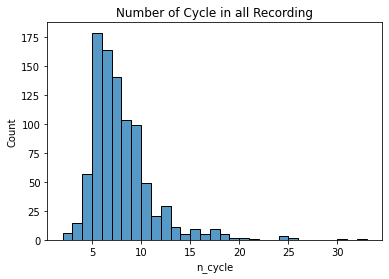

In [57]:
sns.histplot(data=df_files, x='n_cycle', binwidth=1)
plt.title('Number of Cycle in all Recording')

In [34]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [36]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
i = 100
sound_filename = audio_path + df_files['filename'][i] + '.wav'

In [37]:
import IPython.display as ipd
ipd.Audio(sound_filename)

In [50]:
# Displaying sound data 
# time series : amplitude of sound varied in time domain (1D)
# spectogram : amplitude of sound varied in time and frequency domain (2D)

def display_sound(i=0):
    audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
    sound_filename = audio_path + df_files['filename'][i] + '.wav'
    print('diagnosis:', df_files['diagnosis'][i])
    print('general diagnosis:', df_files['diagnosis_general'][i])

    # time series data
    sr_new = 16000 # resample 16 kHz
    x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

    # cut-off the starting non-cycle sound data
    start_time = rec_annotations_dict[df_files['filename'][i]]['Start'][0]
    x = x[int(start_time * sr):]
    
    # Spectogram data 
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))

    # Log-mel spectogram
    mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
    log_mel = librosa.power_to_db(mel, ref=np.max)


    # Mel-Frequency Cepstral Coefficient (MFCC)
    mfccs = librosa.feature.mfcc(x, sr=sr)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    librosa.display.waveplot(y=x, sr=sr, ax=ax[0, 0])
    ax[0, 0].set(title='time series data')

    # Annotating respiratory cycle in time series plot
    annotation = rec_annotations_dict[df_files['filename'][i]]

    for j in range(len(annotation)): 
      ax[0, 0].axvline(float(annotation['Start'][j] - start_time), c='g')
      ax[0, 0].axvline(float(annotation['End'][j] - start_time), c='r')

    librosa.display.specshow(Xdb, x_axis='time',
                            y_axis='log', sr=sr, ax=ax[0, 1])
    ax[0, 1].set(title='spectogram data')

    librosa.display.specshow(log_mel, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=8000, ax=ax[1, 0])
    ax[1, 0].set(title='Log-Mel Spectogram')


    librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
    ax[1, 1].set(title='MFCC')

    plt.suptitle("Display of sound in varies domain", fontsize=14);


interact(display_sound, i=range(0, len(df_files)-1))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.display_sound>

In [ ]:
mfccs.shape

(20, 626)

# Preprocessing

In [ ]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [ ]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)



In [ ]:
preprocessed_data[0].shape

(20, 157)

In [ ]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [ ]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels) 

encoder_3 = LabelEncoder()
i_labels_3 = encoder_3.fit_transform(labels_3)
oh_labels_3 = to_categorical(i_labels_3) 

In [ ]:
print(list(encoder_3.classes_))

['Chronic Disease', 'Healthy', 'Non-Chronic Disease']


In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels_3, stratify=oh_labels_3, 
                                                    test_size=0.2, random_state = 42)

# Training and Testing

Metric : Accuracy, waktu komputasi prediksi 

In [ ]:
from keras.layers.normalization import BatchNormalization

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels_3.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 156, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 78, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 78, 16)         0         
_________________________________________________________________
dense (Dense)                (None, 9, 78, 64)         1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 77, 32)         8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 38, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 38, 32)         0

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# train model
num_epochs = 100
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
12/12 [==============================] - 4s 213ms/step - loss: 2.1190 - accuracy: 0.7853 - val_loss: 0.6126 - val_accuracy: 0.8804

Epoch 00001: val_accuracy improved from -inf to 0.88043, saving model to mymodel2_01.h5
Epoch 2/100
12/12 [==============================] - 2s 193ms/step - loss: 0.6293 - accuracy: 0.8641 - val_loss: 0.6728 - val_accuracy: 0.8207

Epoch 00002: val_accuracy did not improve from 0.88043
Epoch 3/100
12/12 [==============================] - 2s 191ms/step - loss: 0.4299 - accuracy: 0.8777 - val_loss: 0.6873 - val_accuracy: 0.7880

Epoch 00003: val_accuracy did not improve from 0.88043
Epoch 4/100
12/12 [==============================] - 2s 194ms/step - loss: 0.4081 - accuracy: 0.8750 - val_loss: 0.6833 - val_accuracy: 0.7446

Epoch 00004: val_accuracy did not improve from 0.88043
Epoch 5/100
12/12 [==============================] - 2s 192ms/step - loss: 0.3734 - accuracy: 0.8709 - val_loss: 0.6017 - val_accuracy: 0.7500

Epoch 00005: val_accuracy d

<Figure size 432x288 with 0 Axes>

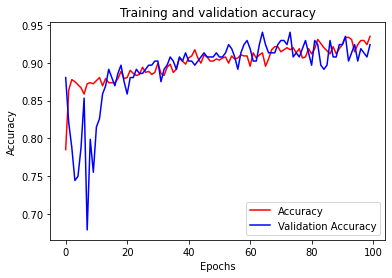

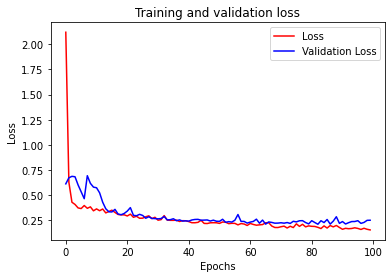

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9130434989929199
Testing Accuracy:  0.9239130616188049


In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=3 # number of classes

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']

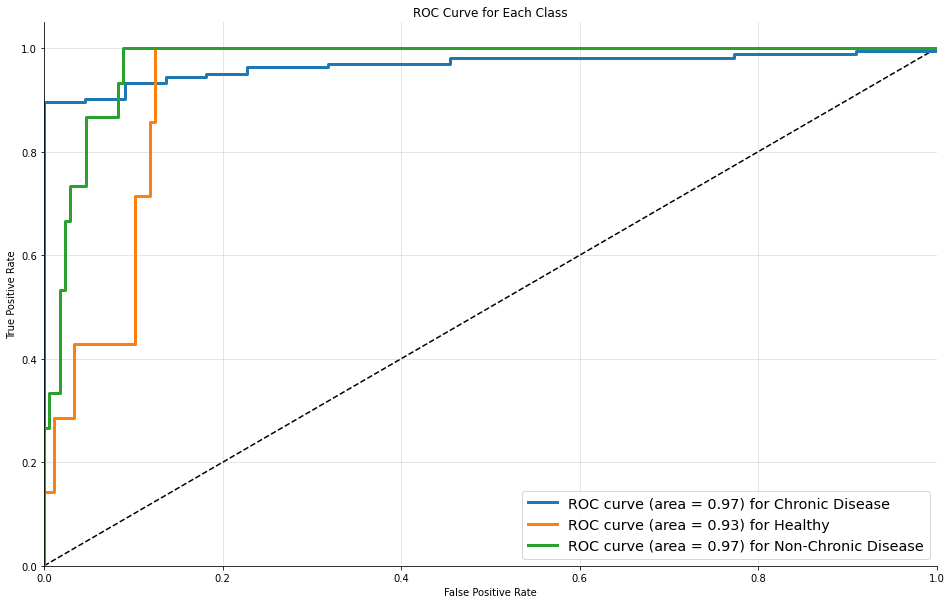

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                     precision    recall  f1-score   support

    Chronic Disease       0.97      0.96      0.96       162
            Healthy       0.50      0.29      0.36         7
Non-Chronic Disease       0.65      0.87      0.74        15

           accuracy                           0.92       184
          macro avg       0.71      0.70      0.69       184
       weighted avg       0.92      0.92      0.92       184



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[155   2   5]
 [  3   2   2]
 [  2   0  13]]


Save model as saved model format

In [ ]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
# saving model in HDF5 format
model.save('prediction_lung_disease_model.h5')

# Lung Disease Prediction

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an sound here 
# and have it classified without crashing
from google.colab import files

# uploading data
uploaded = files.upload()
fn = list(uploaded.keys())

In [ ]:
# load model
# Recreate the exact same model, including its weights and the optimizer
model_path = 'saved_model/my_model'
new_model = tf.keras.models.load_model(model_path)

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 156, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 78, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 78, 16)         0         
_________________________________________________________________
dense (Dense)                (None, 9, 78, 64)         1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 77, 32)         8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 38, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 38, 32)         0

In [ ]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
import numpy as np
import librosa

i = 4
audio_file = audio_path + file_label_df['filename'][i] + '.wav'

# preprocessing sound
data = preprocessing(audio_file, mode='mfcc')
data = np.array(data)
print(data.shape)
data = data.reshape((20, 157, 1))
data = np.expand_dims(data, axis=0)

datas = np.vstack([data])

# Predict sound data
classes = new_model.predict(datas, batch_size=10)
idx = np.argmax(classes)

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']
print('Lunion prediction: \n{}'.format(c_names[idx]))
print('Actual label: \n{}'.format(file_label_df['3 label diagnosis'][i]))
print('Confidence Percentage: {:.2f} %'.format(np.max(classes) * 100))

(20, 157)
Lunion prediction: 
Chronic Disease
Actual label: 
Chronic Disease
Confidence Percentage: 99.99 %


# Integration with mobile

In [ ]:
import pathlib

In [ ]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./respiratory_disease_classifier.tflite')
tflite_model_file.write_bytes(tflite_model)

40000

!pip install tflite-support
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

In [ ]:
AudioClassifierWriter = audio_classifier.MetadataWriter
# The previous tflite file 
_MODEL_PATH = "respiratory_disease_classifier.tflite"
# Create a file labels.txt and store all the Classes 
_LABEL_FILE = "labels.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = 16000
# Expected number of channels of the input audio buffer. Note, Task library only
# support single channel so far.
_CHANNELS = 1
# The previous tflite file with metadata
_SAVE_TO_PATH = "respiratory_disease_classifier_with_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

In [ ]:
# download saved_model
!zip -r /content/saved_model.zip /content/saved_model
from google.colab import files
files.download("/content/saved_model.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 69%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>